In [2]:
import cv2
import numpy as np
from copy_paste import CopyPaste
from coco import CocoDetectionCP
from visualize import display_instances
import albumentations as A
import random
from matplotlib import pyplot as plt
import skimage.io
import pickle
from PIL import Image, ImageDraw, ImageFilter

In [3]:
coco_class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [4]:
voc_classes_names =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [5]:
voc_coco_mutual_classes_names =  ["airplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "dining table", 
                 "dog", "horse", "motorcycle", "person", "potted plant", 
                 "sheep", "couch", "train","tv"]

In [6]:
dic_coco_to_voc ={}
for classStr in voc_coco_mutual_classes_names:
    dic_coco_to_voc[coco_class_names.index(classStr)] = voc_coco_mutual_classes_names.index(classStr)

#### 輸入object mask 算bbox

In [7]:
def findBBoxByMask(mask):
    l = []
    #left to right
    for i in range(mask.shape[1]):
        if True in np.take(mask, i, axis = 1):
            l.append(i)
            break
    #up to down
    for i in range(mask.shape[0]):
        if True in np.take(mask, i, axis = 0):
            l.append(i)
            break
    # right to left
    for i in range(mask.shape[1] - 1, 0, -1):
        if True in np.take(mask, i, axis = 1):
            l.append(i)
            break
    #down to up
    for i in range(mask.shape[0] - 1, 0, -1):
        if True in np.take(mask, i, axis = 0):
            l.append(i)
            break
    return l
        

#### 輸入background image及paste object bbox以及不能超過的百分比，輸出是否超過

In [8]:
def CountAreaOnBoard(w, h, pbox, per):
    total = (pbox[2] - pbox[0]) * (pbox[3] - pbox[1])  
    if(pbox[2] >= w):
        pbox[2] = w - 1
    if(pbox[3] >= h):
        pbox[3] = h - 1
    area = (pbox[2] - pbox[0]) * (pbox[3] - pbox[1])
    if(total == 0.0):
        return False 
    return ( area/ total) >= per

#### 輸入目前圖片中的bbox，以及要貼的bbox，和不能超過的百分比，輸出是否蓋住object面積過大

In [9]:
def CoverAreaOnOtherObject(bbox, bb2, perc):
    
    for bb1 in bbox:
        # determine the coordinates of the intersection rectangle
        x_left = max(bb1[0], bb2[0])
        y_top = max(bb1[1], bb2[1])
        x_right = min(bb1[2], bb2[2])
        y_bottom = min(bb1[3], bb2[3])

        if x_right < x_left or y_bottom < y_top:
            continue

        # The intersection of two axis-aligned bounding boxes is always an
        # axis-aligned bounding box
        intersection_area = (x_right - x_left) * (y_bottom - y_top)

        # compute the area of both AABBs
        bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])

        if (intersection_area / bb1_area) >= perc:
            return True
    return False
        

#### 從data裡面取出BackGround image的bboxes

In [10]:
def FindImageData(img_path):
    training_data_file = open("/work/michael1017/data/comp2/pascal_voc_training_data.txt" , "r")
    bbox = []
    box_classes = []
    for i, line in enumerate(training_data_file):
        line = line.strip()
        ss = line.split(' ')
        image_names = ss[0]
        if (ss[0] == img_path[-10:]):
            break
    num_of_obj = (len(ss) - 1)// 5
    idx = 0
    for i in range(num_of_obj):
        b = []
        for j in range(4):
            idx +=1
            b.append(int(ss[idx]))
        bbox.append(b)
        idx +=1
        box_classes.append(int(ss[idx]))
    return bbox, box_classes
    

CopyPaste<br>
img為被貼上的圖片，image_bbox為圖片中的所有bboxes， image_box_classes為每一個bbox的class， p_img_dic是要貼的物件的資料

In [11]:
def VocCopyPaste(img, image_bbox, image_box_classes, p_img_dic):
    p_img = Image.open(p_img_dic['img_path'])
    with open(p_img_dic['pkl_path'], "rb") as tf:
        p_img_data = pickle.load(tf)
    p_show_masks = p_img_data['masks']
    p_box_classes = p_img_data['class_ids']
    
    bbox = image_bbox
    box_classes = image_box_classes
    
    while(True):
        afa = random.randint(30,200)/ 100.0
        total_area = img.size[0] * img.size[1]
        nw = int(p_img.size[0] * afa)
        nh = int(p_img.size[1] * afa)
        i = p_img_dic['idx']
        mask_image=Image.fromarray(p_show_masks[:,:,i])
        mask_image = mask_image.resize((nw, nh)) 
        area = np.sum(np.array(mask_image))
        if (area / total_area) <= 0.5:
            break
    p_img = p_img.resize((nw, nh))
    p_box = findBBoxByMask(np.array(mask_image))
        
    k = 0
    find = False
    while(k <= 10) : 
        k += 1
        p = random.randint(1, img.size[0])
        q = random.randint(1, img.size[1])
        w = p_box[2]-p_box[0]
        h = p_box[3]-p_box[1]
        a_box = [0,0,0,0]
        a_box[0] = p
        a_box[1] = q
        a_box[2] = p + w
        a_box[3] = q + h
        if(not CountAreaOnBoard(img.size[0], img.size[1], a_box, 0.4)):
            continue
        if(CoverAreaOnOtherObject(bbox, a_box, 0.7)):
            continue
        img.paste(p_img, (p - p_box[0], q-p_box[1]), mask_image) 
        p_box[0] = p
        p_box[1] = q
        p_box[2] = p + w
        p_box[3] = q + h
        if(p_box[2] >= img.size[0]):
            p_box[2] = img.size[0] - 1
        if(p_box[3] >= img.size[1]):
            p_box[3] = img.size[1] - 1
        find = True
        break
    if find == True:    
        bbox.append(p_box)
        box_classes.append(dic_coco_to_voc[p_box_classes[i]])

    bbox = np.array(bbox)
    box_classes = np.array(box_classes) 
    img = np.array(img)
    check_img = np.array(img)
    dic = {}
    for i in range(box_classes.shape[0]):
        l = np.take(bbox, i, axis = 0)
        box_id = np.take(box_classes, i, axis = 0)
        check_img = cv2.rectangle(check_img, (l[0], l[1]), (l[2], l[3]), (0, 255, 255), 3)
        cv2.putText(check_img, voc_classes_names[box_id], (l[0], l[1]), 1,2, (0, 255, 255), 2)
    return img, check_img, bbox, box_classes

In [12]:
with open("/work/michael1017/data/comp2/total_cpaug.pkl", "rb") as tf:
    Dic = pickle.load(tf)

In [13]:
p = random.sample(Dic['dog'], 1)

In [14]:
print(p[0])

{'img_path': '/work/michael1017/data/comp2/VOCdevkit_train/VOC2007/JPEGImages/004008.jpg', 'pkl_path': '/work/michael1017/data/comp2/train_mask_rcnn_result/004008.pkl', 'idx': 0}


In [15]:
img = Image.open("/work/michael1017/data/comp2/VOCdevkit_train/VOC2007/JPEGImages/000099.jpg")

In [16]:
bbox, bbox_classes = FindImageData("/work/michael1017/data/comp2/VOCdevkit_train/VOC2007/JPEGImages/000099.jpg")

In [17]:
img, check_img, bbox, bbox_classes = VocCopyPaste(img, bbox, bbox_classes, random.sample(Dic['cat'], 1)[0])

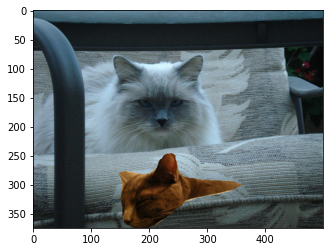

In [18]:
plt.imshow(img)

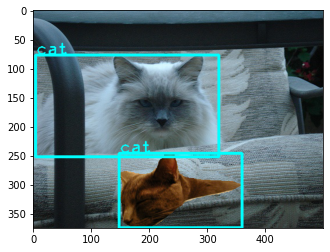

In [19]:
plt.imshow(check_img)

### start

In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
from numpy.random import choice
import os
with open("/work/michael1017/data/comp2/total_cpaug.pkl", "rb") as tf:
    Dic = pickle.load(tf)

In [31]:
Dic.keys()

dict_keys(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'])

In [32]:
for key in Dic.keys():
    print(key + ' = ' + str(len(Dic[key])))

aeroplane = 139
bicycle = 136
bird = 168
boat = 119
bottle = 310
bus = 93
car = 403
cat = 170
chair = 293
cow = 104
diningtable = 169
dog = 220
horse = 135
motorbike = 107
person = 727
pottedplant = 318
sheep = 100
sofa = 129
train = 121
tvmonitor = 127


In [40]:
ori_dic = {}
training_data_file = open("/work/michael1017/data/comp2/VOCdevkit_train/AUG_VOC2007_NEW_2/pascal_voc_aug_training_data.txt" , "r")
for i, line in enumerate(training_data_file):
    line = line.strip()
    ss = line.split(' ')
    image_names = ss[0]
    for i in range(5, len(ss), 5):
        if(ori_dic.get(voc_classes_names[int(ss[i])]) == None):
            ori_dic[voc_classes_names[int(ss[i])]] = 1
        else:
            ori_dic[voc_classes_names[int(ss[i])]] += 1
print(ori_dic)
        

{'aeroplane': 6812, 'cow': 8390, 'diningtable': 6818, 'cat': 6737, 'horse': 6924, 'person': 36372, 'bus': 7241, 'train': 6673, 'sofa': 7301, 'bottle': 8358, 'bird': 7415, 'tvmonitor': 7445, 'motorbike': 7234, 'dog': 7389, 'bicycle': 7298, 'chair': 14345, 'boat': 7555, 'pottedplant': 7858, 'car': 10522, 'sheep': 9059}


In [42]:
num_of_totol_objs = 0
for key in ori_dic.keys():
    num_of_totol_objs += ori_dic[key]

In [48]:
imgPath = "/work/michael1017/data/comp2/VOCdevkit_train/AUG_VOC2007_NEW_3/Image/"
checkImgPath = "/work/michael1017/data/comp2/VOCdevkit_train/AUG_VOC2007_NEW_3/CheckImage/"
bg_img_dir = "/work/michael1017/data/comp2/VOCdevkit_train/VOC2007/JPEGImages_category/"
text_file_dir = "/work/michael1017/data/comp2/VOCdevkit_train/AUG_VOC2007_NEW_3/pascal_voc_aug_training_data.txt"
min_total_obj = 15000

In [44]:
def CountPbDist(ori_dic):
    num_of_totol_objs = 0
    for key in ori_dic.keys():
        num_of_totol_objs += ori_dic[key]
    l = []
    for key in ori_dic.keys():
        l.append(num_of_totol_objs / ori_dic[key])
    total = sum(l)
    for i in  range(0, len(l)):
        l[i] = l[i] / total
    return l

#### 用分布機率去提高取較少的class object來當背景圖及貼紙的機率，盡量達到dataset 的balance

In [49]:
idx = 0
judge = True
while(judge):
    bg_class = choice(list(ori_dic.keys()), 1, p=CountPbDist(ori_dic))
    for root, dirs, files in os.walk(bg_img_dir + bg_class[0]):
        f = choice(files, 1)
        bg_path = root + '/' + f[0]
    img = Image.open(bg_path)
    bbox, bbox_classes = FindImageData(bg_path)
    
    #paste one to three times
    for i in range(random.randint(1, 3)):
        paste_class = choice(list(ori_dic.keys()), 1, p=CountPbDist(ori_dic))
        img, check_img, bbox, bbox_classes = VocCopyPaste(img, bbox, bbox_classes, random.sample(Dic[paste_class[0]], 1)[0])
        img = Image.fromarray(img)
        check_img = Image.fromarray(check_img)
        bbox = bbox.tolist()
        bbox_classes = bbox_classes.tolist()
    
    
    while(True):
        print(idx)
        if(os.path.isfile(imgPath + str(idx).zfill(6) + '.jpg')):
            idx +=1
        else:
            break
    image_name = str(idx).zfill(6) + '.jpg'
    img.save(imgPath + image_name)
    check_img.save(checkImgPath + image_name)
#     check_img.show()
    print("saved :" + image_name)
    
    line = image_name + ' '
    for i in range(len(bbox_classes)):
        for j in range(4):
            line += str(bbox[i][j]) + ' '
        line += str(bbox_classes[i]) + ' '
        ori_dic[voc_classes_names[bbox_classes[i]]] += 1
        
    with open(text_file_dir, 'a') as f:
        f.write(line + '\n')
    
    judge = False
    for key in ori_dic.keys():
        if(ori_dic[key] <= min_total_obj):
            judge = True
            break
    
    idx += 1
    



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [50]:
print(ori_dic)

{'aeroplane': 13038, 'cow': 15839, 'diningtable': 12907, 'cat': 12957, 'horse': 13086, 'person': 69417, 'bus': 13614, 'train': 12713, 'sofa': 14033, 'bottle': 15661, 'bird': 14344, 'tvmonitor': 14076, 'motorbike': 13479, 'dog': 14156, 'bicycle': 13917, 'chair': 27577, 'boat': 14462, 'pottedplant': 14992, 'car': 20589, 'sheep': 17395}


Check 格式

In [609]:
img = Image.open("/work/michael1017/data/comp2/VOCdevkit_train/AUG_VOC2007_NEW/Image/000233.jpg")

In [610]:
def FindImageData2(img_path):
    training_data_file = open("/work/michael1017/data/comp2/VOCdevkit_train/AUG_VOC2007_NEW/pascal_voc_aug_training_data.txt" , "r")
    bbox = []
    box_classes = []
    for i, line in enumerate(training_data_file):
        line = line.strip()
        ss = line.split(' ')
        image_names = ss[0]
        if (ss[0] == img_path[-10:]):
            break
    num_of_obj = (len(ss) - 1)// 5
    idx = 0
    for i in range(num_of_obj):
        b = []
        for j in range(4):
            idx +=1
            b.append(int(ss[idx]))
        bbox.append(b)
        idx +=1
        box_classes.append(int(ss[idx]))
    return bbox, box_classes
    

In [611]:
bbox, bbox_classes = FindImageData2("/work/michael1017/data/comp2/VOCdevkit_train/AUG_VOC2007_NEW/Image/000411.jpg")

In [612]:
img = np.array(img)

In [613]:
for i in range(len(bbox_classes)):
        l = np.take(bbox, i, axis = 0)
        box_id = bbox_classes[i]
        img = cv2.rectangle(img, (l[0], l[1]), (l[2], l[3]), (0, 255, 255), 3)
        cv2.putText(img, voc_classes_names[box_id], (l[0], l[1]), 1,2, (0, 255, 255), 2)

In [614]:
print(bbox)

[[1, 216, 399, 375], [433, 213, 465, 236], [131, 171, 231, 312], [296, 336, 445, 374], [107, 88, 147, 129]]


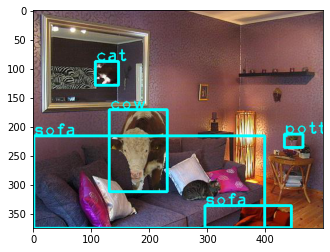

In [615]:
plt.imshow(img)
plt.show()